In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [3]:
train_path='/content/drive/MyDrive/Defect detector/TRAIN'
valid_path='/content/drive/MyDrive/Defect detector/VALID'
test_path='/content/drive/MyDrive/Defect detector/TEST'

In [4]:
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=['crease', 'crescent_gap', 'inclusion', 'Oil_spot', 'punching_hole', 'rolled_pit', 'silk_spot', 'waist folding', 'water_spot', 'welding lines'], batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['crease', 'crescent_gap', 'inclusion', 'Oil_spot', 'punching_hole', 'rolled_pit', 'silk_spot', 'waist folding', 'water_spot', 'welding lines'], batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=['crease', 'crescent_gap', 'inclusion', 'Oil_spot', 'punching_hole', 'rolled_pit', 'silk_spot', 'waist folding', 'water_spot', 'welding lines'], batch_size=10, shuffle=False)

Found 1105 images belonging to 10 classes.
Found 587 images belonging to 10 classes.
Found 602 images belonging to 10 classes.


In [5]:
imgs, labels= next(train_batches)

In [6]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

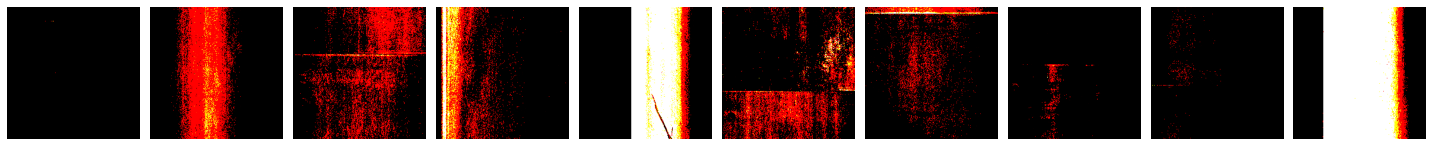

[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]


In [7]:
plotImages(imgs)
print(labels)

In [8]:
conv = keras.applications.xception.Xception(weights='imagenet',
                                            include_top=False,
                                            input_shape=(224,224,3),
                                            pooling='avg')

83689472/83683744 [==============================] - 1s 0us/step


In [9]:
conv.trainable = True

In [10]:
inputs = keras.Input(shape=(224,224,3))
x = conv(inputs)
x1 = keras.layers.Dense(1024,activation='relu')(x)
x1 = keras.layers.Dense(512,activation='relu')(x1)


out1 = keras.layers.Dense(1,name='out1')(x1)
out2 = keras.layers.Dense(1,name='out2')(x1)
out3 = keras.layers.Dense(1,name='out3')(x1)
out4 = keras.layers.Dense(1,name='out4')(x1)

x2 = keras.layers.Dense(1024,activation='relu')(x)
x2 = keras.layers.Dropout(0.5)(x2)
x2 = keras.layers.Dense(512,activation='relu')(x2)
out_class = keras.layers.Dense(10,activation='softmax',name='out_item')(x2)

out = [out1,out2,out3,out4,out_class]

model = keras.models.Model(inputs=inputs,outputs=out)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
xception (Functional)           (None, 2048)         20861480    input_2[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 1024)         2098176     xception[0][0]                   
__________________________________________________________________________________________________
dense (Dense)                   (None, 1024)         2098176     xception[0][0]                   
______________________________________________________________________________________________

In [11]:
model.compile(keras.optimizers.Adam(0.0003),
              loss={'out1':'mse',
                    'out2':'mse',
                    'out3':'mse',
                    'out4':'mse',
                    'out_item':'categorical_crossentropy'},
              metrics=['mae','acc'])

In [12]:
lr_reduce = keras.callbacks.ReduceLROnPlateau('val_loss', patience=6, factor=0.5, min_lr=1e-6)

In [14]:
history = model.fit(x=train_batches,
    steps_per_epoch=len(train_batches),
    validation_data=valid_batches,
    validation_steps=len(valid_batches),
    epochs=5,
    verbose=1
)

Epoch 1/5
111/111 [==============================] - 515s 5s/step - loss: 1.6297 - out1_loss: 0.0913 - out2_loss: 0.0916 - out3_loss: 0.0914 - out4_loss: 0.0914 - out_item_loss: 1.2639 - out1_mae: 0.1783 - out1_acc: 0.9000 - out2_mae: 0.1764 - out2_acc: 0.9000 - out3_mae: 0.1781 - out3_acc: 0.9000 - out4_mae: 0.1769 - out4_acc: 0.9000 - out_item_mae: 0.1063 - out_item_acc: 0.6109 - val_loss: 1.7817 - val_out1_loss: 0.0930 - val_out2_loss: 0.0910 - val_out3_loss: 0.0921 - val_out4_loss: 0.0913 - val_out_item_loss: 1.4143 - val_out1_mae: 0.1519 - val_out1_acc: 0.9000 - val_out2_mae: 0.1718 - val_out2_acc: 0.9000 - val_out3_mae: 0.1579 - val_out3_acc: 0.9000 - val_out4_mae: 0.1711 - val_out4_acc: 0.9000 - val_out_item_mae: 0.0902 - val_out_item_acc: 0.6218
Epoch 2/5
111/111 [==============================] - 36s 321ms/step - loss: 1.0358 - out1_loss: 0.0908 - out2_loss: 0.0905 - out3_loss: 0.0905 - out4_loss: 0.0905 - out_item_loss: 0.6735 - out1_mae: 0.1787 - out1_acc: 0.9000 - out2_mae:

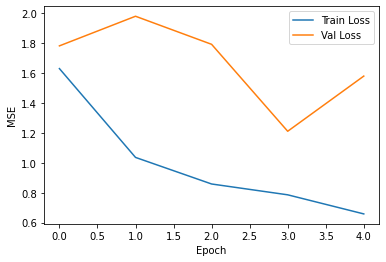

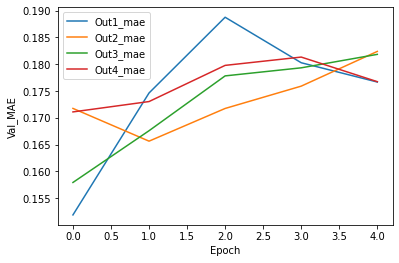

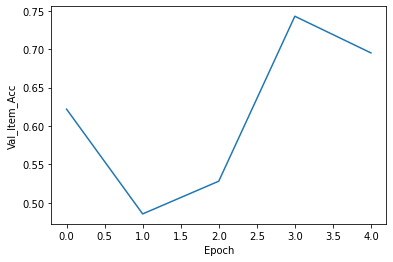

In [17]:
import pandas as pd
def plot_history(history):                
    hist = pd.DataFrame(history.history)           
    hist['epoch']=history.epoch
    
    plt.figure()                                     
    plt.xlabel('Epoch')
    plt.ylabel('MSE')               
    plt.plot(hist['epoch'],hist['loss'],
            label='Train Loss')
    plt.plot(hist['epoch'],hist['val_loss'],
            label='Val Loss')                           
    plt.legend()
    
    plt.figure()                                      
    plt.xlabel('Epoch')
    plt.ylabel('Val_MAE')               
    plt.plot(hist['epoch'],hist['val_out1_mae'],
            label='Out1_mae')
    plt.plot(hist['epoch'],hist['val_out2_mae'],
            label='Out2_mae')
    plt.plot(hist['epoch'],hist['val_out3_mae'],
            label='Out3_mae')
    plt.plot(hist['epoch'],hist['val_out4_mae'],
            label='Out4_mae')
    plt.legend()      
    
    plt.figure()                                      
    plt.xlabel('Epoch')
    plt.ylabel('Val_Item_Acc')               
    plt.plot(hist['epoch'],hist['val_out_item_acc'],
            label='Out5_acc')
    
    plt.show()
    
plot_history(history) 

In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
xception (Functional)           (None, 2048)         20861480    input_2[0][0]                    
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 1024)         2098176     xception[0][0]                   
__________________________________________________________________________________________________
dense (Dense)                   (None, 1024)         2098176     xception[0][0]                   
______________________________________________________________________________________________

In [19]:
model.save("/content/drive/MyDrive/Defect detector/model_5_epochs.h5")